# CSE473s Project

## Part 1 (XOR)
Implement our custom library, test it with [XOR] problem, validate it, and also implement the same exact problem using [TesnorFlow] or [Keras] then compare the results.

### Section-1 (Gradient Checking)

#### Data

In [217]:
import numpy as np

X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y_true = np.array([[0],[1],[1],[0]], dtype=np.float32)

#### Build netwrok with the custom library

In [218]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from lib import Sequential, Dense, Tanh, Sigmoid, ReLU, Softmax, MSELoss, SGDOptimizer as SGD

model = Sequential([
    Dense(2, 2, 0.1), Tanh(), Dense(2, 1, 0.1), Sigmoid()
])

opt = SGD(learning_rate=1.0)
loss_fn = MSELoss()

#### Training loop

In [219]:
n_epochs = 10000

model.fit(X, y_true, loss_fn, opt, epochs=n_epochs)

Epoch 0, Loss: 0.12505627189271182
Epoch 100, Loss: 0.12499282063285541
Epoch 200, Loss: 0.12498966174483284
Epoch 300, Loss: 0.12498509689139846
Epoch 400, Loss: 0.12497800653689099
Epoch 500, Loss: 0.12496605143558462
Epoch 600, Loss: 0.12494364578812314
Epoch 700, Loss: 0.1248948012891193
Epoch 800, Loss: 0.12475964809720003
Epoch 900, Loss: 0.1241924211336847
Epoch 1000, Loss: 0.1193489418257134
Epoch 1100, Loss: 0.07255220908262913
Epoch 1200, Loss: 0.01778796771390173
Epoch 1300, Loss: 0.0076187548568221655
Epoch 1400, Loss: 0.00455085640378922
Epoch 1500, Loss: 0.0031715722960185882
Epoch 1600, Loss: 0.0024077666926623073
Epoch 1700, Loss: 0.0019287748366405629
Epoch 1800, Loss: 0.0016027220932375568
Epoch 1900, Loss: 0.0013675379530002172
Epoch 2000, Loss: 0.001190440847267641
Epoch 2100, Loss: 0.0010525871491220322
Epoch 2200, Loss: 0.0009424184282863153
Epoch 2300, Loss: 0.0008524712654132301
Epoch 2400, Loss: 0.0007777215394184574
Epoch 2500, Loss: 0.0007146686818312347
Epoc

#### Assert correctness

In [231]:
y_pred = model.forward(X)

print("Raw preds:\n", y_pred)
print("Rounded:\n", np.round(y_pred))

y_test = model.forward([-2.0, 3.0])
print("\nTest [-2.0, 3.0]:", np.round(y_test))

Raw preds:
 [[0.01216147]
 [0.98420387]
 [0.98424626]
 [0.0108145 ]]
Rounded:
 [[0.]
 [1.]
 [1.]
 [0.]]

Test [-2.0, 3.0]: [[1.]]


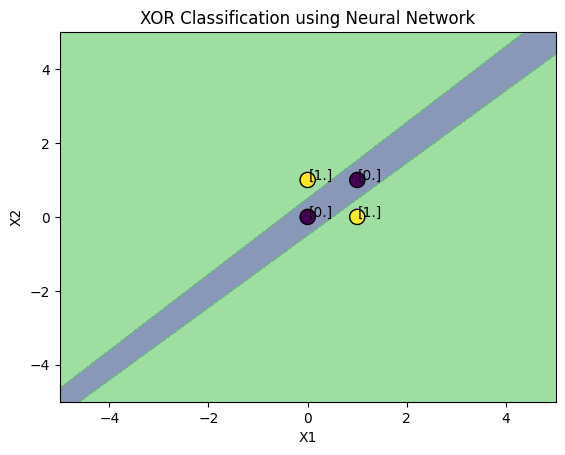

In [221]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points for visualization
xx, yy = np.meshgrid(
    np.linspace(-5.0, 5.0, 200),
    np.linspace(-5.0, 5.0, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]  # shape (40000, 2)

# Predict on the grid
Z = model.forward(grid_points)  # shape (40000, 1)
Z = Z.reshape(xx.shape)         # reshape to (200, 200)

# Plot classification regions
plt.contourf(xx, yy, Z, levels=[0,0.5,1], alpha=0.6)

# Plot XOR data points
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=120, edgecolors='k')
for i, txt in enumerate(y_true):
    plt.text(X[i, 0] + 0.02, X[i, 1] + 0.02, str(txt))

plt.title("XOR Classification using Neural Network")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

#### Gradient-check block

In [222]:
def grad_check(model: Sequential, X, y_true, eps=1e-5):
    loss_fn = MSELoss()
    numeric = []
    analytic = model.layers[0].dW.copy()  # shape of first W

    # numeric
    for idx in np.ndindex(analytic.shape):
        model.layers[0].W[idx] += eps
        plus = loss_fn(y_true, model.forward(X))
        model.layers[0].W[idx] -= 2*eps
        minus = loss_fn(y_true, model.forward(X))
        model.layers[0].W[idx] += eps
        
        numeric.append((plus - minus)/(2*eps))
    
    numeric = np.array(numeric).reshape(analytic.shape)

    # analytic (already stored by model.train_step)
    model.train_step(X, y_true, loss_fn, opt)  # refreshes dW
    analytic = model.layers[0].dW

    return np.abs(analytic - numeric).max()

print('Max diff:', grad_check(model, X, y_true))  # <1e-7 → pass

Max diff: 1.8767539605724082e-14


In [223]:
# Forward
y_pred = model.forward(X)
print("Initial predictions:\n", y_pred)
loss = loss_fn(y_true, y_pred)
print("Initial loss:", loss)

# Backprop once
grad = loss_fn.backward()
model.backward(grad)

# Show gradients stored in Dense layers
for i, layer in enumerate(model.layers):
    if layer.trainable:
        print(f"\nLayer {i} params shapes:", [p.shape for p in [layer.W, layer.b]])
        print("Layer grads shapes:", [g.shape for g in [layer.dW, layer.db]])
        print("Gradients dW:\n", layer.dW[:2,:2])
        print("Gradients db:\n", layer.db[:,:])
    else:
        print(f"\nLayer {i} not trainable")

# Copy params
old_params = [p.copy() for layer in model.layers if layer.trainable for p in [layer.W, layer.b]]

# Step optimizer
opt.step(model.layers)

# Compare params changed
new_params = [p for layer in model.layers if layer.trainable for p in [layer.W, layer.b]]
for old, new in zip(old_params, new_params):
    print("Param change norm:", np.linalg.norm(new - old))


Initial predictions:
 [[0.01216219]
 [0.98420294]
 [0.98424533]
 [0.01081514]]
Initial loss: 9.533036158760666e-05

Layer 0 params shapes: [(2, 2), (1, 2)]
Layer grads shapes: [(2, 2), (1, 2)]
Gradients dW:
 [[-1.87850078e-05  2.10568655e-05]
 [ 1.92969044e-05 -2.10773676e-05]]
Gradients db:
 [[8.84584532e-06 1.02607509e-05]]

Layer 1 not trainable

Layer 2 params shapes: [(2, 1), (1, 1)]
Layer grads shapes: [(2, 1), (1, 1)]
Gradients dW:
 [[-5.60214940e-05]
 [-5.56397264e-05]]
Gradients db:
 [[-5.70204777e-05]]

Layer 3 not trainable
Param change norm: 4.016085218376893e-05
Param change norm: 1.3547397870757788e-05
Param change norm: 7.895686761830566e-05
Param change norm: 5.702047769862162e-05
